In [4]:
import pandas as pd
from lxml import html
from pydantic import BaseModel
from typing import Any, Optional
from unstructured.partition.pdf import partition_pdf

# Use Case

Many documents contain a mixture of content types, including text, images, and tables. 

* `Semi-structured data`: RAG on text and tables has remained a challenge
* `Image`: images often contain valuable information that are excluded from RAG due to model limitations

Here, we show how Unstructured can be used to partition all 3 types from documents. 

And, we show RAG across all these document types.

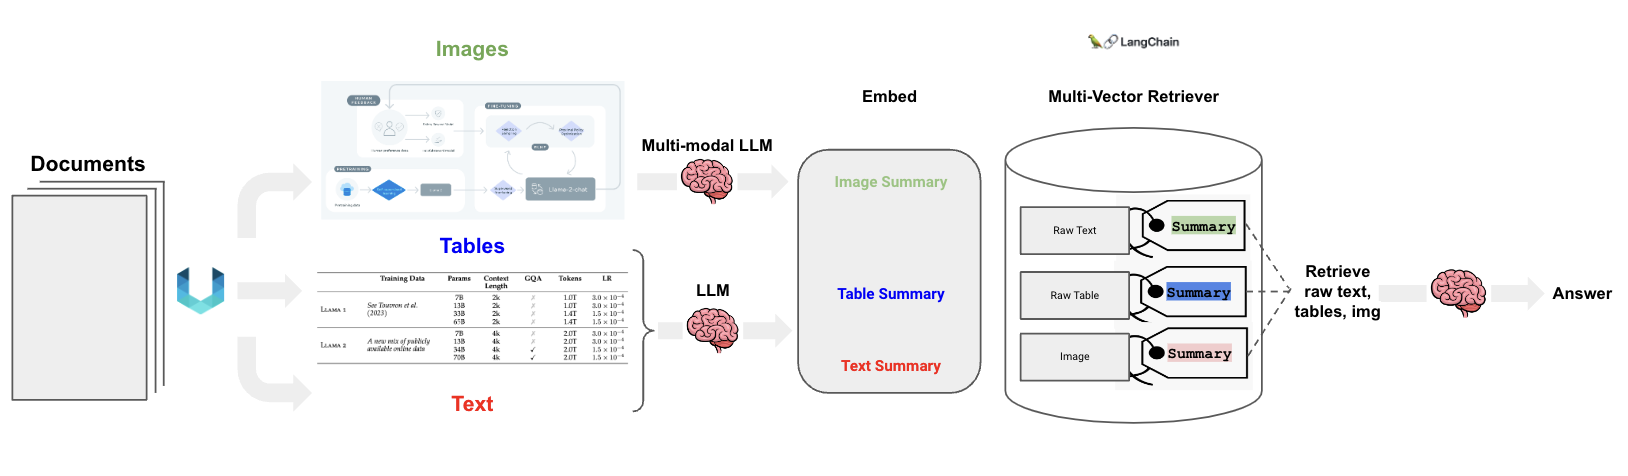

## Data Loading

### Partition PDF tables, text, and images w/ Unstructured
  
* `LLaMA2` Paper: https://arxiv.org/pdf/2307.09288.pdf
* Use `chunking_strategy="by_title"`, which rolls up subsequent non-Table elements under a Title into a `CompositeElement`
* Unstructured also supports [image extraction](https://github.com/Unstructured-IO/unstructured/pull/1371)

In [5]:
img_path = "/Users/rlm/Desktop/Papers/"

In [68]:
# Get elements
raw_pdf_elements = partition_pdf(filename="/Users/rlm/Desktop/Papers/2307.09288.pdf",
                                 chunking_strategy="by_title",
                                 extract_images_in_pdf=True,
                                 infer_table_structure=True,
                                 max_characters=4000,
                                 new_after_n_chars=3800,
                                 image_output_dir_path=img_path)

In [69]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 224,
 "<class 'unstructured.documents.elements.Table'>": 47,
 "<class 'unstructured.documents.elements.TableChunk'>": 2}

In [70]:
class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

49
224


In [75]:
len(text_elements[4].text)

646

In [38]:
# *** Placeholder *** 
# Ideally we get this from Unstructured parsing 
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(        
    chunk_size = 4000,
    chunk_overlap  = 200,
)
texts = [i.text for i in text_elements]
all_text_concat = "".join(texts)
docs = text_splitter.split_text(all_text_concat)
len(docs)

20

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

### Text and Table summaries

In [40]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [41]:
# Prompt 
prompt_text="""You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text) 

# Summary chain 
model = ChatOpenAI(temperature=0,model="gpt-4")
summarize_chain = {"element": lambda x:x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to text
text_summaries = summarize_chain.batch(docs, {"max_concurrency": 5})

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Image summaries 

Use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436): 

* Download `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Clone `llama.cpp` repo
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```

For better performance, try larger LLaVA models or GPT4-V API, when it is released.

In [ ]:
%%bash
# Define the directory containing the images
IMG_DIR=~/Desktop/Papers/

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)
    
    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"
    
    # Execute the command and save the output to the defined output file
    /Users/rlm/Desktop/Code/llama.cpp/build/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --image "$img" > "$output_file"
done

In [59]:
import os, glob

# Get all .txt files in the directory
file_paths = glob.glob(os.path.expanduser(os.path.join(img_path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        img_summaries.append(file.read())

cleaned_img_summary = [s.split("clip_model_load: total allocated memory: 201.27 MB\n\n", 1)[1].strip() for s in img_summaries]

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

In [51]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s,metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [Document(page_content=s,metadata={id_key: img_ids[i]}) for i, s in enumerate(cleaned_img_summary)]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, cleaned_img_summary))) # Store the image summary as the raw document

### Sanity Check

The first table of the present `Llama 2 family of models` with Params and Context Length, etc:

In [52]:
tables[0]

'Training Data Params Context GQA Tokens LR Length 7B 2k 1.0T 3.0x 10-4 See Touvron et al. 13B 2k 1.0T 3.0 x 10-4 LiaMa 1 (2023) 33B 2k 14T 1.5 x 10-4 65B 2k 1.4T 1.5 x 10-4 7B 4k 2.0T 3.0x 10-4 Liama 2 A new mix of publicly 13B 4k 2.0T 3.0 x 10-4 available online data 34B 4k v 2.0T 1.5 x 10-4 70B 4k v 2.0T 1.5 x 10-4'

Here is the summary, which is embedded:

In [53]:
table_summaries[0]

'The table presents different training data parameters for various models. The parameters include the number of tokens (ranging from 7B to 70B), context (2k or 4k), GQA (from 1.0T to 14T), and learning rate (LR) (from 1.5 x 10-4 to 3.0 x 10-4). The models are referenced from different sources, including Touvron et al., LiaMa 1 (2023), LiaMa 2, and a new mix of publicly available online data.'

Here is our retrieval of that table from the natural langugae query:

In [66]:
# We can retrive this table
retriever.get_relevant_documents("What is the number of training tokens for LLaMA2?")[0]

'Training Data Params Context GQA Tokens LR Length 7B 2k 1.0T 3.0x 10-4 See Touvron et al. 13B 2k 1.0T 3.0 x 10-4 LiaMa 1 (2023) 33B 2k 14T 1.5 x 10-4 65B 2k 1.4T 1.5 x 10-4 7B 4k 2.0T 3.0x 10-4 Liama 2 A new mix of publicly 13B 4k 2.0T 3.0 x 10-4 available online data 34B 4k v 2.0T 1.5 x 10-4 70B 4k v 2.0T 1.5 x 10-4'

One of the images from the paper includes a text conversation about Paris.

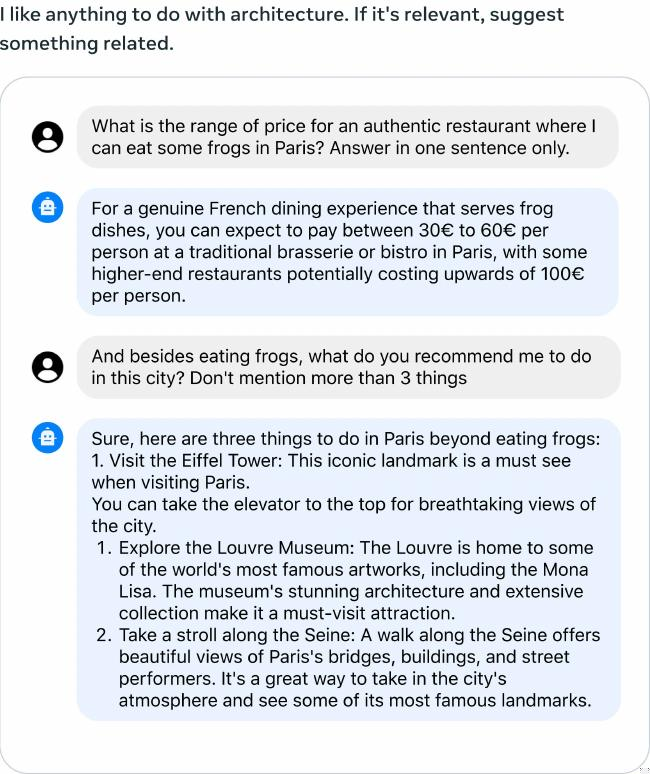

We can retrieve this image summary:

In [67]:
retriever.get_relevant_documents("A conversation about Paris")[1]

'The image contains a series of conversations or messages related to architecture, food, and other topics. There is a group of people engaging in discussions or sharing their thoughts about the subjects. One of the main topics revolves around whether or not to eat frogs, as one person suggests that it is not the best choice. Apart from that, some other discussions seem to involve architecture and its elements, as well as the costs of dining at various restaurants.\n\nThere is also a noticeable presence of restaurants and food in the conversation, with one message referring to a famous landmark in Paris, the Eiffel Tower. The context of this conversation is unclear, but it seems to be a social gathering of people with shared interests in architecture and food.\n\nmain: image encoded in   852.84 ms by CLIP (    1.48 ms per image patch)'

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

In [65]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM
model = ChatOpenAI(temperature=0,model="gpt-4")

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()} 
    | prompt 
    | model 
    | StrOutputParser()
)

In [34]:
chain.invoke("What is the number of training tokens for LLaMA2?")

'The number of training tokens for LLaMA2 is 2 trillion.'

We can check the [trace](https://smith.langchain.com/public/322fd162-845b-4f82-a15c-898e94551967/r) to see what chunks were retrieved:

This includes our table:

```
Training Data Params Context GQA Tokens LR Length 7B 2k 1.0T 3.0x 10-4 See Touvron et al. 13B 2k 1.0T 3.0 x 10-4 LiaMa 1 (2023) 33B 2k 14T 1.5 x 10-4 65B 2k 1.4T 1.5 x 10-4 7B 4k 2.0T 3.0x 10-4 Liama 2 A new mix of publicly 13B 4k 2.0T 3.0 x 10-4 available online data 34B 4k v 2.0T 1.5 x 10-4 70B 4k v 2.0T 1.5 x 10-4
```